In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
import tarfile
import np_utils
from functools import reduce

from nltk.tokenize import word_tokenize

import tensorflow as tf
from tensorflow.keras.layers import Input, Activation, Dense, Dropout, Permute, Embedding, add, concatenate, dot, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import get_file

In [2]:
## using babi-tasks-Dataset
path = get_file('babi-tasks-v1-2.tar.gz',
                origin='https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz')

tar = tarfile.open(path)

11745123/11745123 [==============================] - 9s 1us/step


Data format : 
- A story starts from line 1 to line 15.
- Every 3rd line,  there is a question &amp;amp;amp;amp;amp; answer.

In [3]:
## extracts sub-stories and creates tuples

def parse_stories(lines):
    data = []
    story = []
    for line in lines:
        line = line.decode('utf-8').strip()
        nid, line = line.split(' ', 1)
        nid = int(nid)
        if nid == 1:
            # reset story when line ID=1 (start of new story)
            story = []
        if '\t' in line:
            # this line is tab separated Q, A &amp;amp;amp;amp;amp; support fact ID
            q, a, supporting = line.split('\t')
            # tokenize the words of question
            q = word_tokenize(q)
            # Provide all the sub-stories till this question
            substory = [x for x in story if x]
            # A story ends and is appended to global story data-set
            data.append((substory, q, a))
            story.append('')
        else:
            # this line is a sentence of story
            sent = word_tokenize(line)
            story.append(sent)
    return data

In [4]:
## returns list of all stories in the argument data-set file

def get_stories(f):
    # read the data file and parse 10k stories
    data = parse_stories(f.readlines())
    # lambda func to flatten the list of sentences into one list
    flatten = lambda data: reduce(lambda x, y: x + y, data)
    # creating list of tuples for each story
    data = [(flatten(story), q, answer) for story, q, answer in data]
    return data

In [5]:
challenge = 'tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_{}.txt'

# Extracting train stories
train_stories = get_stories(tar.extractfile(challenge.format('train')))
# Extracting test stories
test_stories = get_stories(tar.extractfile(challenge.format('test')))

In [6]:
vocab = set()

for story,question,answer in train_stories + test_stories:
    vocab |= set(story + question + [answer])

vocab = sorted(vocab)
vocab_size = len(vocab) +1

print(f"Lenght of Vocab  : {len(vocab)}")

Lenght of Vocab  : 21


In [7]:
word_to_idx = {w:idx for idx,w in enumerate(vocab)}
idx_to_word = {idx:w for idx,w in enumerate(vocab)}

story_maxlen = max(map(len,(x for x,_,_ in train_stories +test_stories)))
query_maxlen = max(map(len,(x for _,x,_ in train_stories +test_stories)))

In [8]:
def vectorize_stories(data, word_idx, story_maxlen, query_maxlen):
    X = []  # story vector initialization
    Xq = []  # query vector initialization
    Y = []  # answer vector intialization
    
    for story, query, answer in data:
        x = [word_idx[w] for w in story]  # creating list of story word indices
        xq = [word_idx[w] for w in query]  # creating list of query word indices
        y = np.zeros(len(word_idx) + 1)  # let's not forget that index 0 is reserved
        y[word_idx[answer]] = 1  # creating label 1 for the answer word index
        
        X.append(x)
        Xq.append(xq)
        Y.append(y)
        
    return (pad_sequences(X, maxlen=story_maxlen),
            pad_sequences(Xq, maxlen=query_maxlen), np.array(Y))

In [9]:
# vectorize train story, query and answer sentences/word using vocab
inputs_train, queries_train, answers_train = vectorize_stories(train_stories,word_to_idx,story_maxlen,query_maxlen)

# vectorize test story, query and answer sentences/word using vocab
inputs_test, queries_test, answers_test = vectorize_stories(test_stories,word_to_idx,story_maxlen,query_maxlen)

In [10]:
train_epochs = 100
batch_size = 32
embed_size = 50
lstm_size = 64
dropout_rate = 0.30

In [11]:
# placeholders
input_sequence = Input((story_maxlen,))
question = Input((query_maxlen,))
 
print('Input sequence:', input_sequence)
print('Question:', question)

Input sequence: KerasTensor(type_spec=TensorSpec(shape=(None, 68), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Question: KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [12]:
# encoders

# embed the input sequence into a sequence of vectors
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=embed_size))

input_encoder_m.add(Dropout(dropout_rate))

# output: (samples, story_maxlen, embedding_dim)

In [13]:
# embed the input into a sequence of vectors of size query_maxlen

input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=query_maxlen))

input_encoder_c.add(Dropout(dropout_rate))

# output: (samples, story_maxlen, query_maxlen)

In [14]:
# embed the question into a sequence of vectors

question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embed_size,
                               input_length=query_maxlen))

question_encoder.add(Dropout(dropout_rate))

# output: (samples, query_maxlen, embedding_dim)

In [15]:
# encode input sequence and questions (which are indices)
# to sequences of dense vectors

input_encoded_m = input_encoder_m(input_sequence)
print('Input encoded m', input_encoded_m)

input_encoded_c = input_encoder_c(input_sequence)
print('Input encoded c', input_encoded_c)

question_encoded = question_encoder(question)
print('Question encoded', question_encoded)

Input encoded m KerasTensor(type_spec=TensorSpec(shape=(None, 68, 50), dtype=tf.float32, name=None), name='sequential/dropout/Identity:0', description="created by layer 'sequential'")
Input encoded c KerasTensor(type_spec=TensorSpec(shape=(None, 68, 4), dtype=tf.float32, name=None), name='sequential_1/dropout_1/Identity:0', description="created by layer 'sequential_1'")
Question encoded KerasTensor(type_spec=TensorSpec(shape=(None, 4, 50), dtype=tf.float32, name=None), name='sequential_2/dropout_2/Identity:0', description="created by layer 'sequential_2'")


In [16]:
# compute a 'match' between the first input vector sequence
# and the question vector sequence
# shape: `(samples, story_maxlen, query_maxlen)

match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
print(match.shape)

match = Activation('softmax')(match)
print('Match shape', match)

(None, 68, 4)
Match shape KerasTensor(type_spec=TensorSpec(shape=(None, 68, 4), dtype=tf.float32, name=None), name='activation/Softmax:0', description="created by layer 'activation'")


In [17]:
# add the match matrix with the second input vector sequence

response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)
print('Response shape', response)

Response shape KerasTensor(type_spec=TensorSpec(shape=(None, 4, 68), dtype=tf.float32, name=None), name='permute/transpose:0', description="created by layer 'permute'")


In [18]:
# concatenate the response vector with the question vector sequence

answer = concatenate([response, question_encoded])
print('Answer shape', answer)

Answer shape KerasTensor(type_spec=TensorSpec(shape=(None, 4, 118), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


In [19]:
# Generate tensors of shape 32

answer = LSTM(lstm_size)(answer)
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)

# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

In [20]:
# build the model
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
 
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 68)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 4)]                  0         []                            
                                                                                                  
 sequential (Sequential)     (None, None, 50)             1100      ['input_1[0][0]']             
                                                                                                  
 sequential_2 (Sequential)   (None, 4, 50)                1100      ['input_2[0][0]']             
                                                                                              

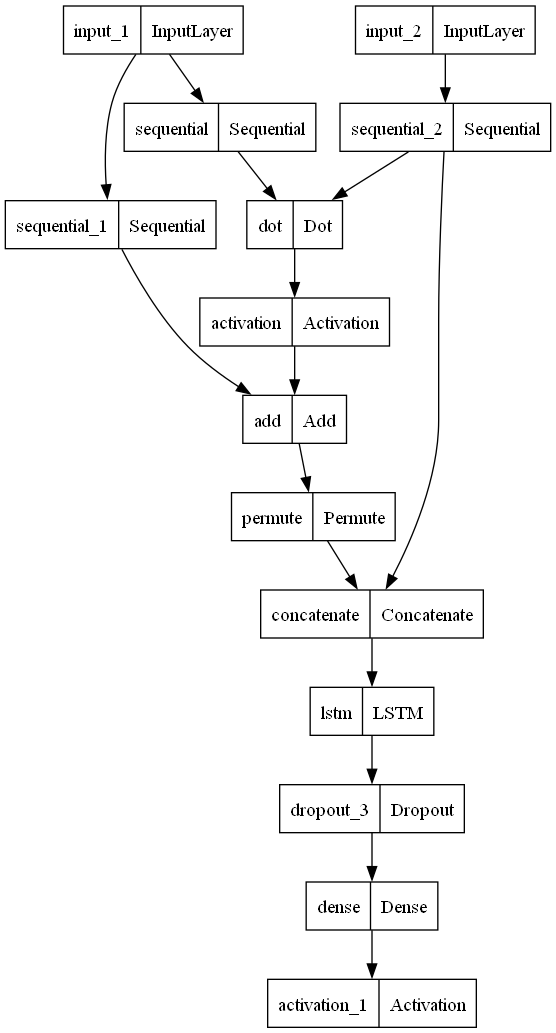

In [21]:
plot_model(model)

In [22]:
# start training the model
history = model.fit([inputs_train, queries_train], answers_train, 
                    batch_size=batch_size, 
                    epochs=train_epochs,
                    validation_data=([inputs_test, queries_test], answers_test))

Epoch 1/100
313/313 [==============================] - 13s 17ms/step - loss: 1.8951 - accuracy: 0.1706 - val_loss: 1.7744 - val_accuracy: 0.2420
Epoch 2/100
313/313 [==============================] - 4s 13ms/step - loss: 1.7193 - accuracy: 0.2373 - val_loss: 1.7898 - val_accuracy: 0.2130
Epoch 3/100
313/313 [==============================] - 4s 13ms/step - loss: 1.6667 - accuracy: 0.2674 - val_loss: 1.6561 - val_accuracy: 0.3340
Epoch 4/100
313/313 [==============================] - 4s 13ms/step - loss: 1.5904 - accuracy: 0.3408 - val_loss: 1.5525 - val_accuracy: 0.3750
Epoch 5/100
313/313 [==============================] - 4s 13ms/step - loss: 1.5048 - accuracy: 0.3995 - val_loss: 1.5007 - val_accuracy: 0.4120
Epoch 6/100
313/313 [==============================] - 4s 13ms/step - loss: 1.4472 - accuracy: 0.4449 - val_loss: 1.4048 - val_accuracy: 0.4640
Epoch 7/100
313/313 [==============================] - 4s 13ms/step - loss: 1.3864 - accuracy: 0.4702 - val_loss: 1.3540 - val_accuracy

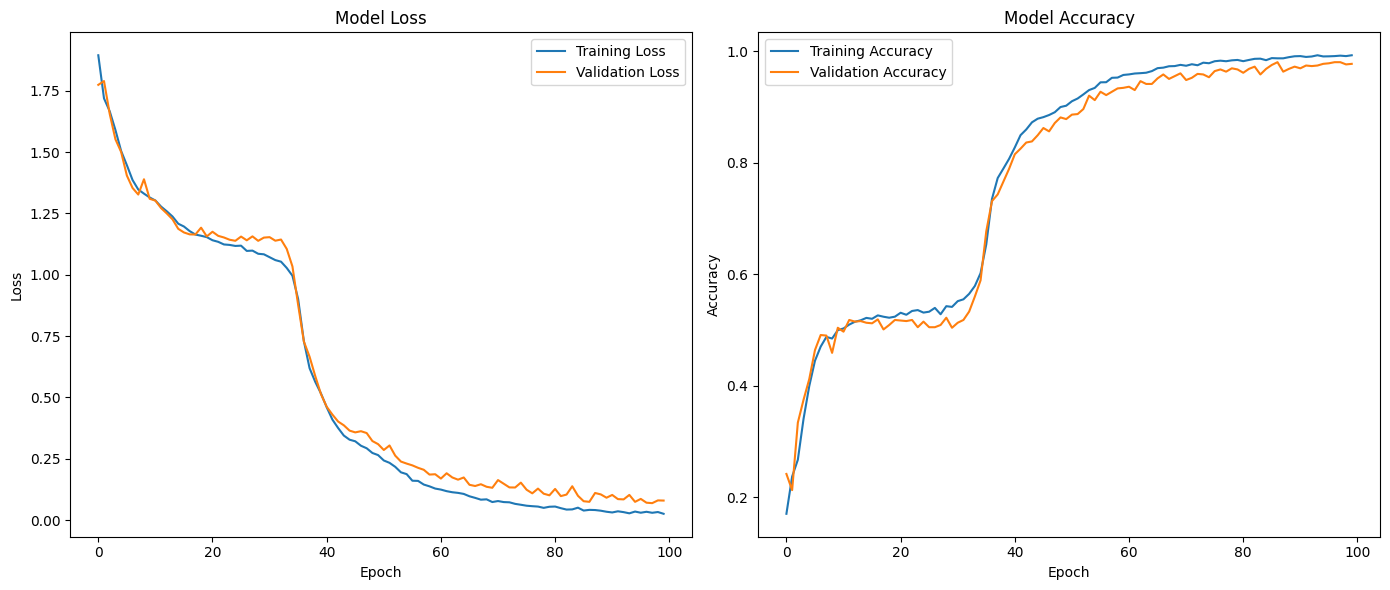

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot Model Loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend()

# Plot Model Accuracy
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Model Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [25]:
# save model
model.save('QA-model.keras')

In [27]:
for i in range(5,35):
    
    current_inp = test_stories[i]
    current_story, current_query, current_answer = vectorize_stories([current_inp], word_to_idx, story_maxlen, query_maxlen)
    
    current_prediction = model.predict([current_story, current_query])
    current_pred = idx_to_word[np.argmax(current_prediction)]
    
    ques = " ".join(current_inp[1])
    print(f"Question : {ques} \nAnswer : {current_pred}")

1/1 [==============================] - 0s 54ms/step
Question : Where is Sandra ? 
Answer : hallway
1/1 [==============================] - 0s 66ms/step
Question : Where is Sandra ? 
Answer : garden
1/1 [==============================] - 0s 63ms/step
Question : Where is Daniel ? 
Answer : hallway
1/1 [==============================] - 0s 64ms/step
Question : Where is Sandra ? 
Answer : office
1/1 [==============================] - 0s 60ms/step
Question : Where is Daniel ? 
Answer : office
1/1 [==============================] - 0s 56ms/step
Question : Where is Mary ? 
Answer : kitchen
1/1 [==============================] - 0s 47ms/step
Question : Where is Mary ? 
Answer : garden
1/1 [==============================] - 0s 54ms/step
Question : Where is Daniel ? 
Answer : office
1/1 [==============================] - 0s 40ms/step
Question : Where is Mary ? 
Answer : bedroom
1/1 [==============================] - 0s 47ms/step
Question : Where is Mary ? 
Answer : bedroom
1/1 [==================